# Sprint-1. Знакомство с задачей и данными

## Задача на этот спринт организаторами не определена 
### (ну или определена в общих фразах, или я просто не выкупил)


## Определю задачу как: 
* Познакомится с данными
* Погонять разные модели
* Погонять разные пред и пост обработки
* Сформировать пайплай
* Прогнать пайплай в эмуляции реал-тайм инференса

###  Содержание <a class="anchor" id=0></a>

- [1. Загрузка библиотек, чтение данных, определение основных функций](#1)
- [2. Песочница с разными моделями](#2)
- [3. Песочница с разными пайплайнами](#3)
- [4. Эмуляция реал-тайм инференса](#4)
- [5. Итоги спринта](#5)


## 1. Загрузка библиотек, чтение данных, определение основных функций <a class="anchor" id=1></a>

[к содержанию](#0)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

free_movements = pd.read_csv('free_movements.csv', index_col=0)

OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
INDEX = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'RUN time'] # для удобства вывода отчетов
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements.shape[-1]

gestures_train = pd.read_csv('gestures_train.csv', index_col=0)
gestures_test = pd.read_csv('gestures_test.csv', index_col=0)
gestures_protocol = pd.read_csv('gestures_protocol.csv')

gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

Забегая вперёд, при обработке данных и подборе модели, будем пользоваться функциями которые понадобятся в эмуляции `inferenc'а` в `real-time`.

In [5]:
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse


def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def preprocessing_static(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y, axis=1)

def inference(x):
    """_получение предсказаний модели_

    """
    y = np.rint(model.predict(x))

    return y

def postprocessing(array):
    """_дискретизация предсказаний модели
        используется в качестве постпроцессинга
        сюда желательно добавить сглаживатель пиков_
    
    """
    array[array < 10] = 0
    array[(array > 10) & (array <20)] = 10
    array[(array > 20) & (array <30)] = 20
    array[(array > 30) & (array <40)] = 30
    array[(array > 40) & (array <50)] = 40
    array[(array > 50) & (array <60)] = 50
    array[(array > 60) & (array <70)] = 60
    array[(array > 70) & (array <80)] = 70
    array[(array > 80) & (array <90)] = 80
    array[(array > 90) & (array <95)] = 90
    array[array > 95] = 100
    return array


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

## 2. Песочница с разными моделями <a class="anchor" id=2></a>

[к содержанию](#0)

Пробовать модели будем на "чистых" данных

In [3]:
X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values
X.shape, y.shape, X_test.shape, y_test.shape

((33172, 50), (33172, 6), (8168, 50), (8168, 6))

Отправной точкой примем линейную регрессию на чистых данных, без пред и пост обработки.

In [18]:
# время выполнения ~ 0.3s
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

LR = pd.DataFrame({'INDEX':INDEX, 'LinearRegression':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('LinearRegression RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

LinearRegression RAW


,train,test
GLOVE_CH,,
ENC0,44.761241,57.252958
ENC1,35.262227,37.579762
ENC2,47.073603,48.509950
ENC3,207.066172,263.154448
ENC4,423.469831,546.546481
ENC5,0.000000,0.000000


In [19]:
# время выполнения ~ 4s
from sklearn.linear_model import ElasticNet

model = ElasticNet().fit(X,y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

EN = pd.DataFrame({'INDEX':INDEX, 'ElasticNet':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('ElasticNet RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

ElasticNet RAW


,train,test
GLOVE_CH,,
ENC0,44.873820,56.565240
ENC1,35.338241,37.519686
ENC2,47.210088,48.693002
ENC3,207.355253,264.983272
ENC4,423.804671,549.683325
ENC5,0.000000,0.000000


In [20]:
# время выполнения ~ 0,1s
from sklearn.linear_model import LassoLars

model = LassoLars().fit(X,y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

LL = pd.DataFrame({'INDEX':INDEX, 'LassoLars':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('LassoLars RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

LassoLars RAW


,train,test
GLOVE_CH,,
ENC0,44.973118,56.332148
ENC1,35.432681,37.594363
ENC2,47.342738,48.876090
ENC3,207.715352,266.192403
ENC4,424.298050,551.437323
ENC5,0.000000,0.000000


In [21]:
print('Итог по линейкам "из коробки":')
Linear_df = pd.concat([LR, EN, LL], axis=1)
Linear_df

Итог по линейкам "из коробки":


,LinearRegression,ElasticNet,LassoLars
INDEX,,,
ENC0,57.252958,56.565240,56.332148
ENC1,37.579762,37.519686,37.594363
ENC2,48.509950,48.693002,48.876090
ENC3,263.154448,264.983272,266.192403
ENC4,546.546481,549.683325,551.437323
ENC5,0.000000,0.000000,0.000000
RUN time,0.021450,0.016374,0.013897


***
Теперь будем пробовать градиентные бустеры

In [22]:
# время выполнения ~ 1m40s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

model = MultiOutputRegressor(GradientBoostingRegressor(random_state=32)).fit(X, y)

start_time = time.time()
y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

GBR = pd.DataFrame({'INDEX':INDEX, 'GradientBoostingRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('GradientBoostingRegressor RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

GradientBoostingRegressor RAW


,train,test
GLOVE_CH,,
ENC0,16.912123,28.175583
ENC1,15.087552,30.575872
ENC2,19.207656,35.629204
ENC3,74.554328,214.932725
ENC4,127.723987,353.940632
ENC5,0.000000,0.000000


In [23]:
# время выполнения ~ 15s
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=mse)
model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

XGB = pd.DataFrame({'INDEX':INDEX, 'XGBRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('XGBRegressor RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

XGBRegressor RAW


,train,test
GLOVE_CH,,
ENC0,1.967498e+00,3.268807e+01
ENC1,1.846818e+00,2.980621e+01
ENC2,2.608701e+00,3.082462e+01
ENC3,8.093385e+00,2.156292e+02
ENC4,1.912600e+01,3.609346e+02
ENC5,2.622217e-32,2.622217e-32


In [24]:
# время выполнения ~ 4s
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

model = MultiOutputRegressor(lgb.LGBMRegressor())
model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

LGB = pd.DataFrame({'INDEX':INDEX, 'LGBMRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('XGBRegressor RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

XGBRegressor RAW


,train,test
GLOVE_CH,,
ENC0,5.017942,28.124781
ENC1,4.764639,27.244121
ENC2,6.383497,29.265750
ENC3,20.524104,173.373193
ENC4,39.268853,309.614289
ENC5,0.000000,0.000000


In [25]:
print('Итог по бустерам "из коробки":')
Booster_df = pd.concat([GBR, XGB, LGB], axis=1)
Booster_df

Итог по бустерам "из коробки":


,GradientBoostingRegressor,XGBRegressor,LGBMRegressor
INDEX,,,
ENC0,28.175583,3.268807e+01,28.124781
ENC1,30.575872,2.980621e+01,27.244121
ENC2,35.629204,3.082462e+01,29.265750
ENC3,214.932725,2.156292e+02,173.373193
ENC4,353.940632,3.609346e+02,309.614289
ENC5,0.000000,2.622217e-32,0.000000
RUN time,0.302205,1.051550e-01,0.183059


***
Теперь будем пробовать деревянные регрессоры

In [26]:
# время выполнения ~ 2min
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor().fit(X,y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

RFR = pd.DataFrame({'INDEX':INDEX, 'RandomForestRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('RandomForestRegressor RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

RandomForestRegressor RAW


,train,test
GLOVE_CH,,
ENC0,1.102681,36.358728
ENC1,0.921864,34.896987
ENC2,1.069558,27.972450
ENC3,3.862548,199.514362
ENC4,5.750676,395.919230
ENC5,0.000000,0.000000


In [27]:
# время выполнения ~ 40s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import BaggingRegressor

model = MultiOutputRegressor(BaggingRegressor())
model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_train_pred = model.predict(X_test)

BR = pd.DataFrame({'INDEX':INDEX, 'BaggingRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('BaggingRegressor RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

BaggingRegressor RAW


,train,test
GLOVE_CH,,
ENC0,1.371530,36.358728
ENC1,1.157843,34.896987
ENC2,1.564681,27.972450
ENC3,6.026557,199.514362
ENC4,10.575348,395.919230
ENC5,0.000000,0.000000


In [28]:
# время выполнения ~ 30s
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_train_pred = model.predict(X_test)

ETR = pd.DataFrame({'INDEX':INDEX, 'ExtraTreesRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('ExtraTreesRegressor RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

ExtraTreesRegressor RAW


,train,test
GLOVE_CH,,
ENC0,0.0,36.358728
ENC1,0.0,34.896987
ENC2,0.0,27.972450
ENC3,0.0,199.514362
ENC4,0.0,395.919230
ENC5,0.0,0.000000


In [29]:
print('Итог по деревьям "из коробки":')
Tree_df = pd.concat([RFR, BR, ETR], axis=1)
Tree_df

Итог по деревьям "из коробки":


,RandomForestRegressor,BaggingRegressor,ExtraTreesRegressor
INDEX,,,
ENC0,36.358728,36.358728,36.358728
ENC1,34.896987,34.896987,34.896987
ENC2,27.972450,27.972450,27.972450
ENC3,199.514362,199.514362,199.514362
ENC4,395.919230,395.919230,395.919230
ENC5,0.000000,0.000000,0.000000
RUN time,0.485880,0.477355,0.559230


Попробуем стакнуть несколько линеек

In [30]:
# время выполнения ~ 35s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model = MultiOutputRegressor(StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
))

model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

ST = pd.DataFrame({'INDEX':INDEX, 'StackingRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('StackingRegressor')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

StackingRegressor


,train,test
GLOVE_CH,,
ENC0,18.628891,34.914353
ENC1,18.491740,26.511151
ENC2,22.674540,36.582108
ENC3,71.044572,213.710620
ENC4,145.429003,436.205021
ENC5,0.000000,0.000000


In [31]:
# время выполнения ~ 7s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model = MultiOutputRegressor(VotingRegressor(estimators=estimators))

model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

VR = pd.DataFrame({'INDEX':INDEX, 'VotingRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('VotingRegressor')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

VotingRegressor


,train,test
GLOVE_CH,,
ENC0,11.243279,30.583405
ENC1,8.858170,27.866550
ENC2,11.835685,36.672662
ENC3,51.928838,215.259204
ENC4,106.074513,418.763349
ENC5,0.000000,0.000000


In [32]:
print('Итог по базовым стекам:')
Stacks_df = pd.concat([ST, VR], axis=1)
Stacks_df

Итог по базовым стекам:


,StackingRegressor,VotingRegressor
INDEX,,
ENC0,34.914353,30.583405
ENC1,26.511151,27.866550
ENC2,36.582108,36.672662
ENC3,213.710620,215.259204
ENC4,436.205021,418.763349
ENC5,0.000000,0.000000
RUN time,0.072826,0.075633


In [33]:
print('Итог по базовым моделям "из коробки":')
Models_df = pd.concat([Linear_df, Booster_df, Tree_df, Stacks_df], axis=1)
Models_df

Итог по базовым моделям "из коробки":


,LinearRegression,ElasticNet,LassoLars,GradientBoostingRegressor,XGBRegressor,LGBMRegressor,RandomForestRegressor,BaggingRegressor,ExtraTreesRegressor,StackingRegressor,VotingRegressor
INDEX,,,,,,,,,,,
ENC0,57.252958,56.565240,56.332148,28.175583,3.268807e+01,28.124781,36.358728,36.358728,36.358728,34.914353,30.583405
ENC1,37.579762,37.519686,37.594363,30.575872,2.980621e+01,27.244121,34.896987,34.896987,34.896987,26.511151,27.866550
ENC2,48.509950,48.693002,48.876090,35.629204,3.082462e+01,29.265750,27.972450,27.972450,27.972450,36.582108,36.672662
ENC3,263.154448,264.983272,266.192403,214.932725,2.156292e+02,173.373193,199.514362,199.514362,199.514362,213.710620,215.259204
ENC4,546.546481,549.683325,551.437323,353.940632,3.609346e+02,309.614289,395.919230,395.919230,395.919230,436.205021,418.763349
ENC5,0.000000,0.000000,0.000000,0.000000,2.622217e-32,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RUN time,0.021450,0.016374,0.013897,0.302205,1.051550e-01,0.183059,0.485880,0.477355,0.559230,0.072826,0.075633


***
## Подведём промежуточныйе итоги:
* Линейки **очень** быстрые, но обладают низкой точностью

* Бустеры из коробки показывают **приличные отправные метрики**, но оставляют совсем мало времени на пред и пост обработку сигналов

* "Деревья" медленные и с так-себе метриками

Имеем проблему знакомую любым игрокам в РПГ, кого будем качать? Сильного дебила или умного слабака?
На данном этапе, я бы продолжил вести в параллель 2 сценария:

1. Стек из линейки и дерева собранный на **VotingRegressor** с кучей пред и пост обработки

2. **XGBRegressor** с оптимизацией параметров и минимумом пост обработки

## 3. Песочница с разными пайплайнами <a class="anchor" id=3></a>

[к содержанию](#0)

К этому этапу **не сработало**:
1. Стандартизация и нормализация (`MinMaxScaler`, `RobustScaler`, `StandardScaler`)

2. Полиномиальные фичи и трансформеры (`PolynomialFeatures`, `PowerTransformer`, `QuantileTransformer`)

Хотелось бы в предпроцессинге реализовать "умное сглаживание датчиков" на основе 2-3 изменений (нужно буферное окно)

Попробуем с текущим предпроцессингом: добавление в предикты разницы в показаниях датчиков за 1 шаг.

И постпроцессингом: помещаем все предсказания в диапазон от 0 до 100 и дискретизируем предсказания на 11 диапазонов (по верхам шаг можно уменьшить)

In [48]:
# время выполнения ~ 27s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model = MultiOutputRegressor(VotingRegressor(estimators=estimators))

X = preprocessing(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing(X_test, np.vstack((X_test[1:], X_test[:1])))

model.fit(X, y)

start_time = time.time()

y_pred = inference(X)
y_pred = postprocessing(y_pred)
y_pred = commands(y_pred, np.vstack((y_pred[1:], y_pred[:1])))

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = inference(X_test)
y_test_pred = postprocessing(y_test_pred)
y_test_pred = commands(y_test_pred, np.vstack((y_test_pred[1:], y_test_pred[:1])))


VR_post = pd.DataFrame({'INDEX':INDEX, 'VR pred&post':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('VR pred&post')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

VR pred&post


,train,test
GLOVE_CH,,
ENC0,35.608706,31.953477
ENC1,33.737565,39.372490
ENC2,28.681524,41.583986
ENC3,63.219598,176.088026
ENC4,99.758486,331.563173
ENC5,0.000000,0.000000


In [49]:
# время выполнения ~ 4s
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb


X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values


model = MultiOutputRegressor(lgb.LGBMRegressor())

X = preprocessing_static(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing_static(X_test, np.vstack((X_test[1:], X_test[:1])))

model.fit(X, y)

start_time = time.time()

y_pred = inference(X)
y_pred = postprocessing(y_pred)
y_pred = commands(y_pred, np.vstack((y_pred[1:], y_pred[:1])))

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = inference(X_test)
y_test_pred = postprocessing(y_test_pred)
y_test_pred = commands(y_test_pred, np.vstack((y_test_pred[1:], y_test_pred[:1])))

LGB_post = pd.DataFrame({'INDEX':INDEX, 'LGBMR pred&post':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('LGBMR pred&post')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

LGBMR pred&post


,train,test
GLOVE_CH,,
ENC0,31.129778,27.531342
ENC1,30.181403,26.281158
ENC2,23.571190,24.621756
ENC3,30.663753,144.143548
ENC4,39.529980,309.220189
ENC5,0.000000,0.000000


Подберём гиперпараметры `Optun'ой`

In [35]:
import optuna
def optuna_lgb(trial):
  
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 10, 150, 1)
    max_depth = trial.suggest_int('max_depth', 15, 100, 1)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 200, 1)
    
    
    model_op = MultiOutputRegressor(lgb.LGBMRegressor(
                                        metric = 'l2', 
                                        random_state = 32,
                                        learning_rate = learning_rate,
                                        num_leaves = num_leaves,
                                        max_depth = max_depth,
                                        min_data_in_leaf = min_data_in_leaf
                                    ))

    model_op.fit(X, y)
    score = MSE(y_test, model_op.predict(X_test))[4]

    return score

In [37]:
study = optuna.create_study(study_name="LGBMR pred&post", direction="minimize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lgb, n_trials=100, show_progress_bar=True)

[I 2023-05-08 19:00:26,168] A new study created in memory with name: LGBMR pred&post


  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[I 2023-05-08 19:00:28,801] Trial 0 finished with value: 288.92491147784193 and parameters: {'learning_rate': 0.1244060627253343, 'num_leaves': 18, 'max_depth': 20, 'min_data_in_leaf': 114}. Best is trial 0 with value: 288.92491147784193.
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[I 2023-05-08 19:00:34,840] Trial 1 finished with value: 324.78223557643213 and parameters: {'learning_rate': 0.06626514369896673, 'num_leaves': 104, 'max_depth': 78, 'min_data_in_leaf': 139}. Best is trial 0 with value: 288.92491147784193.
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[I 2023-05-08 19:00:39,688] Trial 2 finished with value: 294.13038113599157 and parameters: {'learning_rate': 0.16620708848660457, 'num_leaves': 105

In [38]:
best_params = study.best_params
best_params

{'learning_rate': 0.2572978923100677,
 'num_leaves': 32,
 'max_depth': 35,
 'min_data_in_leaf': 108}

In [50]:
# время выполнения ~ 5s
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values

model = MultiOutputRegressor(lgb.LGBMRegressor( 
                                learning_rate = 0.25,
                                num_leaves = 30,
                                max_depth = 30,
                                min_data_in_leaf = 100))

X = preprocessing(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing(X_test, np.vstack((X_test[1:], X_test[:1])))

model.fit(X, y)

start_time = time.time()

y_pred = inference(X)
y_pred = postprocessing(y_pred)
y_pred = commands(y_pred, np.vstack((y_pred[1:], y_pred[:1])))

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = inference(X_test)
y_test_pred = postprocessing(y_test_pred)
y_test_pred = commands(y_test_pred, np.vstack((y_test_pred[1:], y_test_pred[:1])))

LGB_post = pd.DataFrame({'INDEX':INDEX, 'LGBMR pred&post':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('LGBMR pred&post')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
LGBMR pred&post


,train,test
GLOVE_CH,,
ENC0,28.947365,27.794564
ENC1,28.440628,27.981085
ENC2,20.972010,27.189398
ENC3,23.978973,161.879530
ENC4,30.371805,268.254224
ENC5,0.000000,0.000000


На этом месте хорошо бы прикрутить сглаживатели и фильты на показания датчиков, а может и не хорошо, ктож знает?..
Я на всякий случай добавлю к предиктам изменения в показаниях датчиков за последний шаг.

In [53]:
print('Итог по базовым моделям "из коробки":')
Final_df = pd.concat([VR_post, LGB_post], axis=1)
Final_df

Итог по базовым моделям "из коробки":


,VR pred&post,LGBMR pred&post
INDEX,,
ENC0,31.953477,27.794564
ENC1,39.372490,27.981085
ENC2,41.583986,27.189398
ENC3,176.088026,161.879530
ENC4,331.563173,268.254224
ENC5,0.000000,0.000000
RUN time,0.196609,0.308596


***
## Подведём промежуточныйе итоги:

* Стек линеек **ощутимо быстрее**, но нуждается в дополнительной обработке, **больше авторегрессий богу авторегрессий**

* 10~15ms уходит на пред и постпроцессинг, опчти половина отведённого времени, а выхлоп от них минимален.

## 4. Эмуляция реал-тайм инференса <a class="anchor" id=4></a>

[к содержанию](#0)

In [2]:
import time
import serial
from IPython.display import clear_output


In [3]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

In [6]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model_vr = MultiOutputRegressor(VotingRegressor(estimators=estimators))

X = preprocessing_static(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing_static(X_test, np.vstack((X_test[1:], X_test[:1])))

model_vr.fit(X, y)

MultiOutputRegressor(estimator=VotingRegressor(estimators=[('dt',
                                                            DecisionTreeRegressor()),
                                                           ('ll',
                                                            LassoLars())]))

In [7]:
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb


X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values


model_lgbm = MultiOutputRegressor(lgb.LGBMRegressor())

X = preprocessing_static(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing_static(X_test, np.vstack((X_test[1:], X_test[:1])))

model_lgbm.fit(X, y)

MultiOutputRegressor(estimator=LGBMRegressor())

In [8]:
from sklearn.metrics import mean_squared_error as mse

def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def preprocessing(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y)

def inference(x):
    """_получение предсказаний модели_
        np.rint - для дотягивания float'ов до ближайших int'ов
    """
    return model_vr.predict(x.reshape(1,-1))[0]


def postprocessing(array):
    """_дискретизация предсказаний модели
        используется в качестве постпроцессинга
        сюда желательно добавить сглаживатель пиков_
    
    """
    array[array < 10] = 0
    array[(array > 10) & (array <20)] = 10
    array[(array > 20) & (array <30)] = 20
    array[(array > 30) & (array <40)] = 30
    array[(array > 40) & (array <50)] = 40
    array[(array > 50) & (array <60)] = 50
    array[(array > 60) & (array <70)] = 60
    array[(array > 70) & (array <80)] = 70
    array[(array > 80) & (array <90)] = 80
    array[(array > 90) & (array <95)] = 90
    array[array > 95] = 100
    return array


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

In [29]:
df_sim = gestures_test.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(8168, 65)


In [25]:
TIMEOUT = 0.033
DEBUG = True

ts_list = [] 
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
omg_previous = None # эту переменную добавил для "супер умного" препроцессинга, в иделае тут всякие сглаживатели бы накрутить


y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, omg_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
  
    # [/Data logging]

    y_previous = y_postprocessed # для сглаживания 
    omg_previous = omg_sample # просто чтобы была
    
    ts_list.append(ts_diff) # проверю времена выполнения
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 1000, SYNC: 26, TS: 8947611
[15. 10.  5.  5. 30.  0.]


In [26]:
#y_dct['y_commands'] = y_dct['y_commands'][1:]

for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (2000, 50)
enc_sample.shape = (2000, 6)
sample_preprocessed.shape = (2000, 100)
y_predicted.shape = (2000, 6)
y_postprocessed.shape = (2000, 6)
y_commands.shape = (2000, 6)


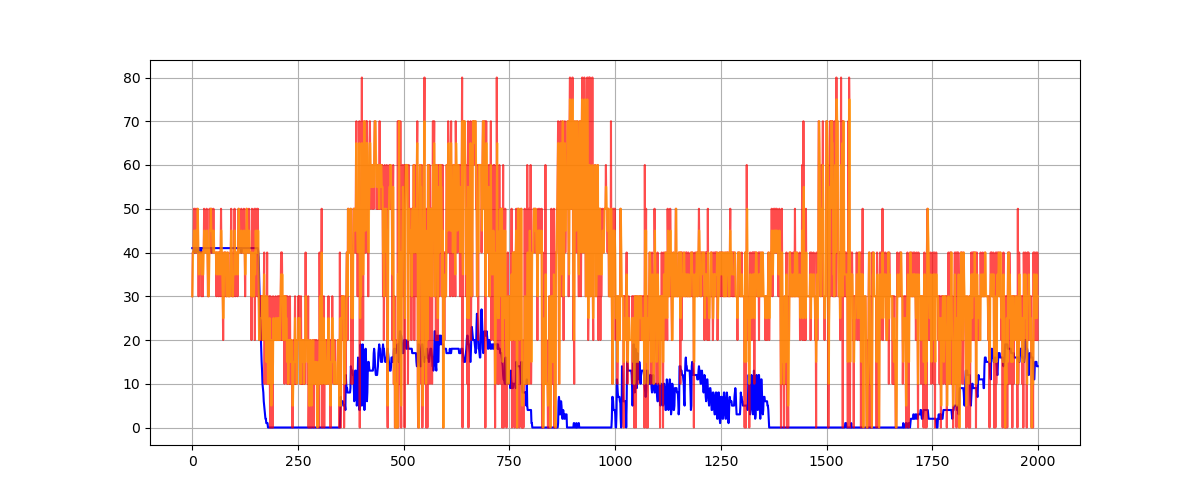

In [27]:
plt.clf()
fig = plt.figure(figsize=(12, 5))

plt.plot(y_dct['enc_sample'][:,4], color='blue')
plt.plot(y_dct['y_postprocessed'][:,4], color='red', alpha=0.7)
plt.plot(y_dct['y_commands'][:,4], color='orange', alpha=0.7)
plt.grid()


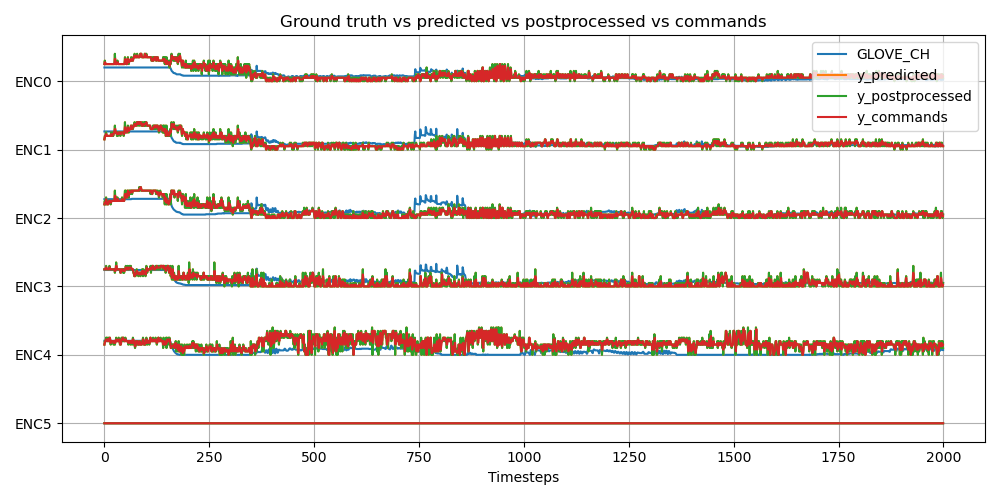

In [28]:
plt.clf()
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

***

In [9]:
from sklearn.metrics import mean_squared_error as mse

def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def preprocessing(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y)

def inference(x):
    """_получение предсказаний модели_
        np.rint - для дотягивания float'ов до ближайших int'ов
    """
    return model_lgbm.predict(x.reshape(1,-1))[0]


def postprocessing(array):
    """_дискретизация предсказаний модели
        используется в качестве постпроцессинга
        сюда желательно добавить сглаживатель пиков_
    
    """
    array[array < 10] = 0
    array[(array > 10) & (array <20)] = 10
    array[(array > 20) & (array <30)] = 20
    array[(array > 30) & (array <40)] = 30
    array[(array > 40) & (array <50)] = 40
    array[(array > 50) & (array <60)] = 50
    array[(array > 60) & (array <70)] = 60
    array[(array > 70) & (array <80)] = 70
    array[(array > 80) & (array <90)] = 80
    array[(array > 90) & (array <95)] = 90
    array[array > 95] = 100
    return array


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

In [10]:
df_sim = gestures_test.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(8168, 65)


In [14]:
TIMEOUT = 0.033
DEBUG = True

ts_list = [] 
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
omg_previous = None # эту переменную добавил для "супер умного" препроцессинга, в иделае тут всякие сглаживатели бы накрутить


y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, omg_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
  
    # [/Data logging]

    y_previous = y_postprocessed # для сглаживания 
    omg_previous = omg_sample # просто чтобы была
    
    ts_list.append(ts_diff) # проверю времена выполнения
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 


SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 1000, SYNC: 539, TS: 7856565
[ 5. 10. 10. 20. 45.  0.]


In [16]:
#y_dct['y_commands'] = y_dct['y_commands'][1:]

for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8168, 50)
enc_sample.shape = (8168, 6)
sample_preprocessed.shape = (8168, 100)
y_predicted.shape = (8168, 6)
y_postprocessed.shape = (8168, 6)
y_commands.shape = (8168, 6)


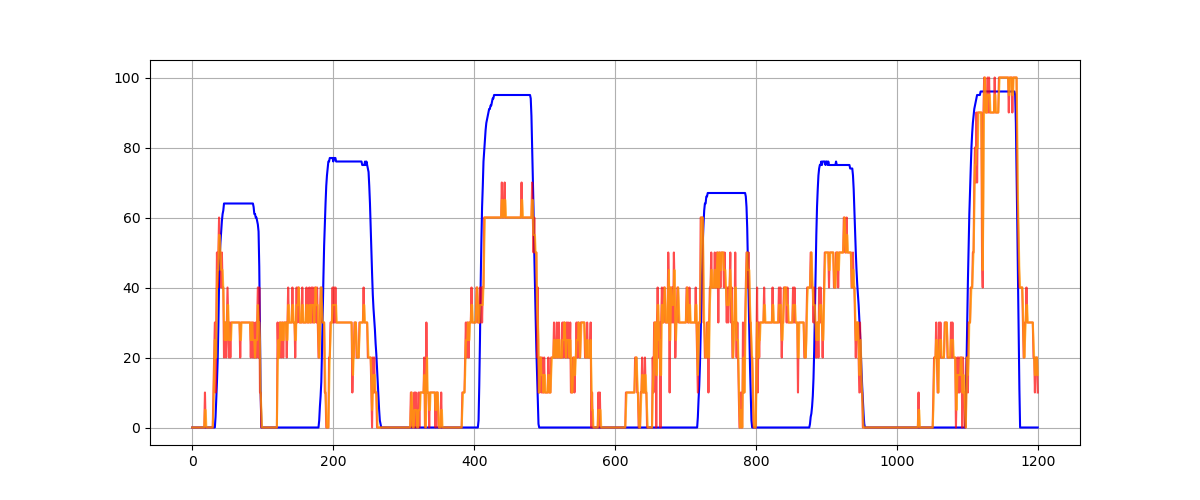

In [21]:
plt.clf()
fig = plt.figure(figsize=(12, 5))

plt.plot(y_dct['enc_sample'][:,4][5800:7000], color='blue')
plt.plot(y_dct['y_postprocessed'][:,4][5800:7000], color='red', alpha=0.7)
plt.plot(y_dct['y_commands'][:,4][5800:7000], color='orange', alpha=0.7)
plt.grid()

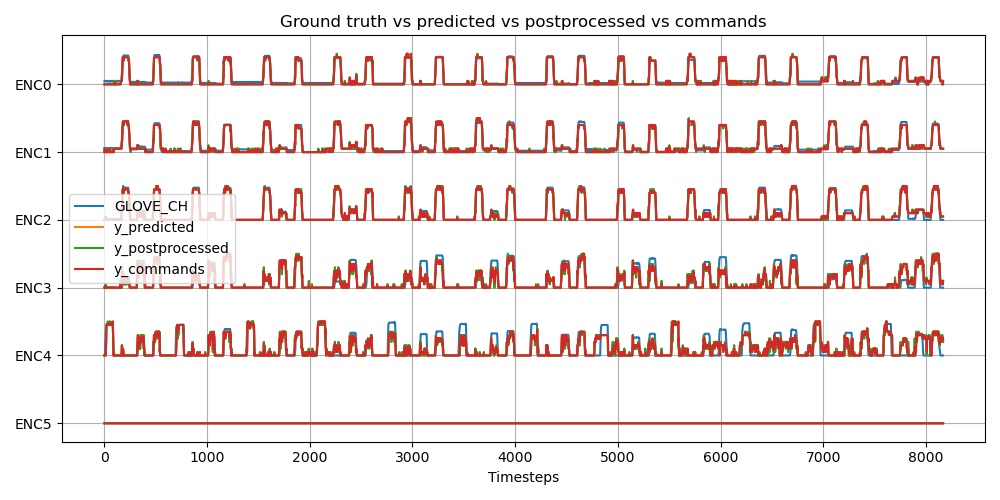

In [22]:
plt.clf()
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

## 5. Итоги спринта <a class="anchor" id=5></a>

[к содержанию](#0)

Я **очень** надеюсь, что правильно определил задачу первого спринта, как "общее знакомство с данными", потому, что на тестовых данных, модельки худо - бедно, но что-то показать могут, а вот со свободными жестами беда.. 

Но всё же:

* Стек из линейки и дерева вполне способен решить поставленную задачу.

* А градиентный бустинг буд-то бы созда для её решения.

* Но решения можно достигнуть при условии доработки **пред и постпроцессинга**, возможные пути:

* * Сглаживание показаний датчиков (где-то тут можно попробовать приложить авторегрессию)

* * Отсекание неинформативных датчиков (как определить какие датчики и **когда** являются "неинформативными" - отдельный вопрос)

* * Нужно больше узнать хардовую часть датчиков и процесса сьъёма показаний (хочется большей универсальности показаний, чтобы не было сильной разницы от "монтажа" и от "пилота", на данном этапе интуитивно хочется брать не сами показания а изменения в абсолютных значениях)

* * На постпроцессинге нужно срезать пики и убирать биения (сюда тоже можно приложить авторегрессию)


